In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

class Node:
    def __init__(self, name, value):
        self.name = name
        self.value = value

class Edge:
    def __init__(self, from_node, to_node, func):
        self.from_node = from_node
        self.to_node = to_node
        self.func = func
    
    def apply_func(self):
        delta = self.func(self.from_node, self.to_node)
        self.from_node.value -= delta
        self.to_node.value += delta
        
class Graph:
    def __init__(self):
        self.nodes = dict()
        self.edges = dict()
        self.dfs_order = None
    def add_node(self, node):
        self.nodes[node.name] = node
        self.dfs_order = None
    
    def add_edge(self, edge):
        name = edge.from_node.name
        edges = self.edges.get(name, [])
        edges.append(edge)
        self.edges[name] = edges
        self.dfs_order = None
    
    def dfs_visit(self, node, visited: set):
        res = []
        for e in self.edges.get(node.name, []):
            if e.to_node.name not in visited:
                visited.add(e.to_node.name)
                res += self.dfs_visit(e.to_node, visited)
        res.append(node)
        return res
    
    def dfs(self):
        visited = set()
        res = []
        for node in self.nodes.values():
            if node.name not in visited:
                res += self.dfs_visit(node, visited)
        return res
    
    def initilize(self):
        self.dfs_order = self.dfs()


    def iteration(self):
        if self.dfs_order is None:
            self.initilize()
        
        for n in self.dfs_order:
            for e in self.edges.get(n.name,[]):
                e.apply_func()
        

In [2]:
def sir_graph(infected, alpha, beta):
    graph = Graph()
    s_node = Node("S", 1-infected)
    i_node = Node("I", infected)
    r_node = Node("R", 0)

    graph.add_node(s_node)
    graph.add_node(i_node)
    graph.add_node(r_node)

    si_edge = Edge(s_node, i_node, lambda x,y: (x.value*y.value*np.random.binomial(10000, max(min(alpha, 1), 0))/10000))
    ir_edge = Edge(i_node, r_node, lambda x,y: (x.value*np.random.binomial(10000, max(min(beta, 1), 0))/10000))

    graph.add_edge(si_edge)
    graph.add_edge(ir_edge)
    return graph

In [3]:
def simulation(graph: Graph, steps=1000):
    graph.initilize()
    res = dict()
    for node in graph.dfs_order:
        res[node.name] = [node.value]
    
    for _ in range(steps):
        graph.iteration()
        for node in graph.dfs_order:
            res[node.name].append(node.value)
    return res


In [4]:
def create_windows(arr, size, step):
    res = []
    poz = 0
    while(poz+size <len(arr)):
        res.append(arr[poz:poz+size])
        poz += step
    return res

In [5]:
def create_simulation_data(infected, alpha, beta, windows_size, windows_step, simulation_steps):
    graph = sir_graph(infected, alpha, beta)
    sim = simulation(graph, simulation_steps)
    sim_windowed = dict()
    for k in sim.keys():
        sim_windowed[k] = create_windows(sim[k], windows_size, windows_step)
    res = dict()
    for i in range(len(sim_windowed[k])):
        good_window = True
        for k in sim.keys():
            good_window &= np.std(sim_windowed[k][i]) > 1e-5
        if good_window:
            for k in sim.keys():
                ar = res.get(k, [])
                ar.append(sim_windowed[k][i])
                res[k] = ar
    return res


In [7]:
import tqdm
train_data = []
# for a in tqdm.tqdm(range(1000)):
#     a = np.random.sample()
   
#     b = np.random.sample()
#     data = create_simulation_data(1e-6, a, b, 30, 15, 365)
#     if "S" in data:
#         for i in range(len(data["S"])):
#             row = dict()
#             row["a"] = a
#             row["b"] = b
#             row["S"] = data["S"][i]
#             row["I"] = data["I"][i]
#             row["R"] = data["R"][i]
#             train_data.append(row)

In [8]:
import multiprocessing
from functools import reduce
train_data = []


def generate_data(i):
    res = []
    a = np.random.sample()*0.4
    b = np.random.sample()*0.4
    data = create_simulation_data(1e-6, a, b, 30, 15, 90)
    if "S" in data:
        for i in range(len(data["S"])):
            row = dict()
            row["a"] = a
            row["b"] = b
            row["S"] = data["S"][i]
            row["I"] = data["I"][i]
            row["R"] = data["R"][i]
            res.append(row)
    return res



In [9]:
pool = multiprocessing.Pool(11)
for rows in tqdm.tqdm(pool.imap_unordered(generate_data, range(1000000)), total=1000000):
    for row in rows:
        train_data.append(row)
    pass
pool.close()
pool.join()
pool.close()

100%|██████████| 1000000/1000000 [04:23<00:00, 3794.01it/s]


In [10]:
len(train_data)

1205086

In [51]:
from sklearn.model_selection import train_test_split
def prepare_train_data(data):
    X = []
    y = []
    for row in data:
        X.append(row["I"]+row["R"])
        y.append([row["a"], row["b"]])
    return X,y

X,y = prepare_train_data(train_data)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
y_test = np.array(y_test)
y_train = np.array(y_train)
len(X_train), len(X_test)

(903814, 301272)

### look up train and test data

[0.3750554  0.04513945]


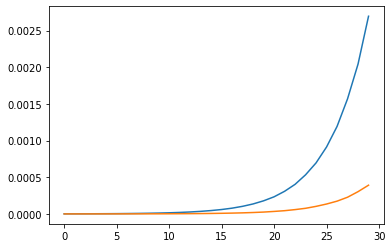

In [55]:
i=6
plt.plot(X_train[i][:30])
plt.plot(X_train[i][30:])
print(y_train[i])

In [56]:
def mse(a, b):
    a = np.array(a)
    a[a==np.inf] = 0
    b[b==np.inf] = 0
    return np.mean((a-b)**2)
def compare_simulations(first_a, first_b, second_a, second_b, infected=1e-6):
    graph = sir_graph(infected, first_a, first_b)
    first = simulation(graph, 60)
    
    graph = sir_graph(infected, second_a, second_b)
    second = simulation(graph, 60)
  
    res = [mse(first["S"], second["S"]), mse(first["I"], second["I"]), mse(first["R"], second["R"])]
    return res

In [57]:
#Random

y_pred_a = np.random.sample(len(X_test))*0.4
y_pred_b = np.random.sample(len(X_test))*0.4

print("A mse", np.mean(y_pred_a-y_test[:,0])**2)
print("B mse", np.mean(y_pred_b-y_test[:,1])**2)
errors = []
# for first, second in tqdm.tqdm(zip(y_test, zip(y_pred_a, y_pred_b))):
#     errors.append(compare_simulations(first[0], first[1], second[0], second[1]))
# errors = np.array(errors)
# errors[errors == np.inf] = 0 #Something is broken TODO Regression can return value that is > 1
# print("Mean error of simulation (order S I R):")
# np.mean(errors, axis=0) # SIR

A mse 0.00860886288815198
B mse 0.013101096959247965


In [58]:
from sklearn.linear_model import LinearRegression

model_a = LinearRegression()
model_b = LinearRegression()
model_a.fit(X_train, y_train[:,0])
model_b.fit(X_train, y_train[:,1])
y_pred_a = model_a.predict(X_test)
y_pred_b = model_b.predict(X_test)
print("A mse", np.mean(y_pred_a-y_test[:,0])**2)
print("B mse", np.mean(y_pred_b-y_test[:,1])**2)
errors = []
# for first, second in tqdm.tqdm(zip(y_test, zip(y_pred_a, y_pred_b))):
#     errors.append(compare_simulations(first[0], first[1], second[0], second[1]))
# errors = np.array(errors)
# errors[errors == np.inf] = 0 #Something is broken TODO Regression can return value that is > 1
# print("Mean error of simulation (order S I R):")
# np.mean(errors, axis=0) # SIR

A mse 5.7676636351385706e-08
B mse 3.4204320437737422e-09


In [59]:
from sklearn.tree import DecisionTreeRegressor

model_a = DecisionTreeRegressor()
model_b = DecisionTreeRegressor()
model_a.fit(X_train, y_train[:,0])
model_b.fit(X_train, y_train[:,1])
y_pred_a = model_a.predict(X_test)
y_pred_b = model_b.predict(X_test)
print("A mse", np.mean(y_pred_a-y_test[:,0])**2)
print("B mse", np.mean(y_pred_b-y_test[:,1])**2)

# errors = []
# for first, second in tqdm.tqdm(zip(y_test, zip(y_pred_a, y_pred_b))):
#     errors.append(compare_simulations(first[0], first[1], second[0], second[1]))
# errors = np.array(errors)
# errors[errors == np.inf] = 0 #Something is broken
# print("Mean error of simulation (order S I R):", np.mean(errors, axis=0))

A mse 1.0976399862094086e-12
B mse 1.554466175256709e-13


In [60]:
from sklearn.neighbors import KNeighborsRegressor

model_a = KNeighborsRegressor(1)
model_b =  KNeighborsRegressor(1)
model_a.fit(X_train, y_train[:,0])
model_b.fit(X_train, y_train[:,1])
y_pred_a = model_a.predict(X_test)
y_pred_b = model_b.predict(X_test)
print("A mse", np.mean(y_pred_a-y_test[:,0])**2)
print("B mse", np.mean(y_pred_b-y_test[:,1])**2)

errors = []
# for first, second in tqdm.tqdm(zip(y_test, zip(y_pred_a, y_pred_b))):
#     errors.append(compare_simulations(first[0], first[1], second[0], second[1]))
# errors = np.array(errors)
# errors[errors == np.inf] = 0 #Something is broken
# print("Mean error of simulation (order S I R):", np.mean(errors, axis=0))



A mse 1.5103501585071249e-15
B mse 3.351320618983655e-15


In [17]:
# from sklearn.ensemble import RandomForestRegressor
# model_a = RandomForestRegressor(100, n_jobs=11)
# model_b =  RandomForestRegressor(100, n_jobs=11)
# model_a.fit(X_train, y_train[:,0])
# model_b.fit(X_train, y_train[:,1])
# y_pred_a = model_a.predict(X_test)
# y_pred_b = model_b.predict(X_test)
# print("A mse", np.mean(y_pred_a-y_test[:,0])**2)
# print("B mse", np.mean(y_pred_b-y_test[:,1])**2)

# errors = []
# for first, second in tqdm.tqdm(zip(y_test, zip(y_pred_a, y_pred_b))):
#     errors.append(compare_simulations(first[0], first[1], second[0], second[1]))
# errors = np.array(errors)
# errors[errors == np.inf] = 0 #Something is broken
# print("Mean error of simulation (order S I R):", np.mean(errors, axis=0))


In [18]:
# from sklearn.ensemble import AdaBoostRegressor

# model_a = AdaBoostRegressor()
# model_b =  AdaBoostRegressor()
# model_a.fit(X_train, y_train[:,0])
# model_b.fit(X_train, y_train[:,1])
# y_pred_a = model_a.predict(X_test)
# y_pred_b = model_b.predict(X_test)
# print("A mse", np.mean(y_pred_a-y_test[:,0])**2)
# print("B mse", np.mean(y_pred_b-y_test[:,1])**2)

# errors = []
# for first, second in tqdm.tqdm(zip(y_test, zip(y_pred_a, y_pred_b))):
#     errors.append(compare_simulations(first[0], first[1], second[0], second[1]))
# errors = np.array(errors)
# errors[errors == np.inf] = 0 #Something is broken
# print("Mean error of simulation (order S I R):", np.mean(errors, axis=0))


NYC real data

In [61]:
!wget https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv

--2020-05-10 15:04:34--  https://raw.githubusercontent.com/nychealth/coronavirus-data/master/case-hosp-death.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485 (1.5K) [text/plain]
Saving to: ‘case-hosp-death.csv’

case-hosp-death.csv 100%[===================>]   1.45K  --.-KB/s    in 0s      

2020-05-10 15:04:35 (9.61 MB/s) - ‘case-hosp-death.csv’ saved [1485/1485]



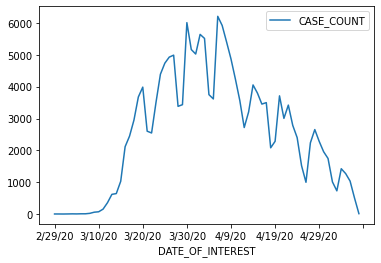

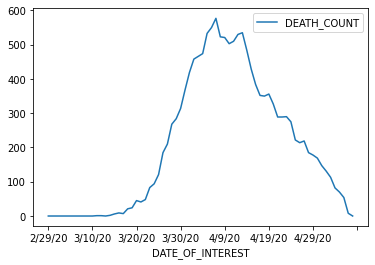

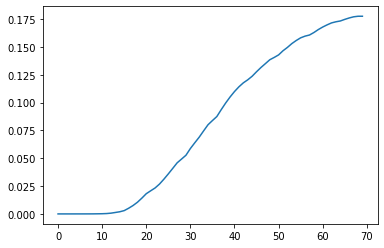

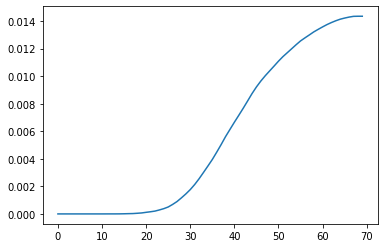

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("case-hosp-death.csv")
df = df.fillna(0)

df.plot(x ='DATE_OF_INTEREST', y='CASE_COUNT')
df.plot(x ='DATE_OF_INTEREST', y='DEATH_COUNT')
plt.show()
infected = df["CASE_COUNT"].to_numpy()
death = df["DEATH_COUNT"].to_numpy()

for i in range(1, infected.shape[0]):
    infected[i] += infected[i-1]
    death[i] += death[i-1]
#NYC_N = 8e6
NYC_N = 1e6
infected = infected/NYC_N
death = death/NYC_N
plt.plot(range(len(infected)), infected, label="I")
# plt.plot(range(len(infected)), death, label="D")
plt.show()
plt.plot(range(len(infected)), death, label="D")


In [49]:
#Prediction 


model_a = KNeighborsRegressor(100, p=1)
model_b = KNeighborsRegressor(100, p=1)
model_a.fit(X_train, y_train[:,0])
model_b.fit(X_train, y_train[:,1])


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=100, p=1,
                    weights='uniform')

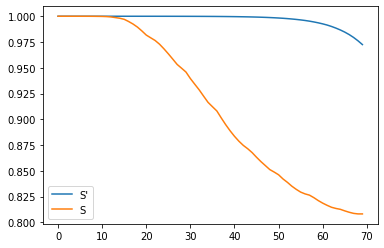

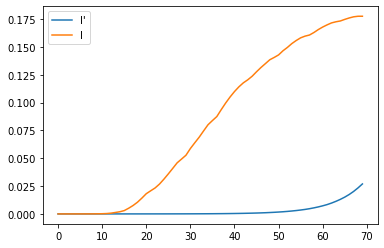

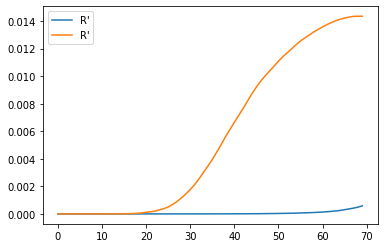

(0.16372662131353755, 0.0032540206651411998)

In [65]:
alpha = model_a.predict(np.concatenate([infected[:30], death[:30]]).reshape(1,-1))[0]
beta = model_b.predict(np.concatenate([infected[:30], death[:30]]).reshape(1, -1))[0]

sir = sir_graph(infected[0], alpha, beta)

S = []
I = []
R = []
for i in range(len(infected)):
    S.append(sir.nodes["S"].value)
    I.append(sir.nodes["I"].value)
    R.append(sir.nodes["R"].value)

    sir.iteration()

plt.plot(range(len(infected)), S, label="S'")
plt.plot(range(len(infected)), np.ones_like(infected)-infected-death, label="S")
plt.legend()
plt.show()

plt.plot(range(len(infected)), I, label="I'")
plt.plot(range(len(infected)), infected, label="I")

plt.legend()
plt.show()

plt.plot(range(len(infected)), R, label="R'")
plt.plot(range(len(infected)), death, label="R'")
plt.legend()
plt.show()

alpha, beta

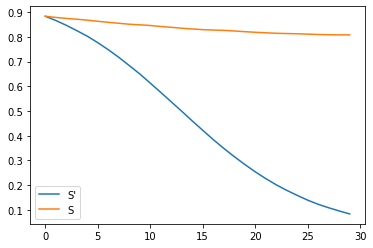

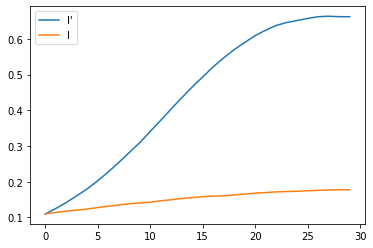

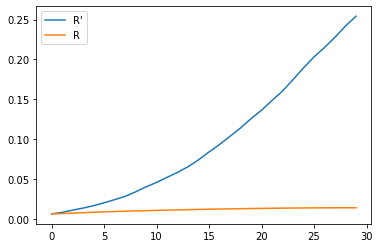

(0.18288063132317053, 0.020138382362609744)

In [66]:
# Last 30 days


alpha = model_a.predict(np.concatenate([infected[-30:], death[-30:]]).reshape(1,-1))[0]
beta = model_b.predict(np.concatenate([infected[-30:], death[-30:]]).reshape(1, -1))[0]

sir = sir_graph(infected[-30], alpha, beta)

sir.nodes["I"].value = infected[-30]
sir.nodes["R"].value = death[-30]
sir.nodes["S"].value = 1-infected[-30]-death[-30]
S = []
I = []
R = []
for i in range(30):
    S.append(sir.nodes["S"].value)
    I.append(sir.nodes["I"].value)
    R.append(sir.nodes["R"].value)

    sir.iteration()

plt.plot(range(30), S, label="S'")
plt.plot(range(30), (np.ones_like(infected)-infected-death)[-30:], label="S")
plt.legend()
plt.show()

plt.plot(range(30), I, label="I'")
plt.plot(range(30), infected[-30:], label="I")

plt.legend()
plt.show()

plt.plot(range(30), R, label="R'")
plt.plot(range(30), death[-30:], label="R")
plt.legend()
plt.show()

alpha, beta

0.109854


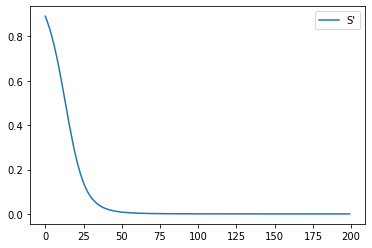

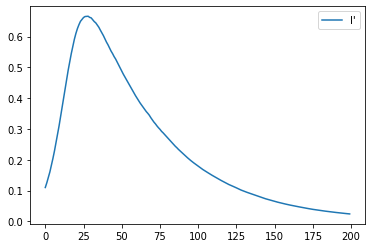

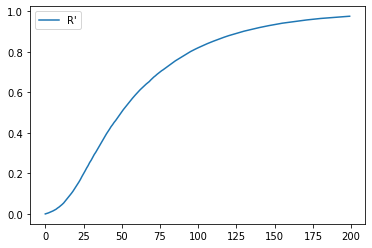

In [67]:
#Forecasting

alpha = model_a.predict(np.concatenate([infected[-30:], death[-30:]]).reshape(1,-1))[0]
beta = model_b.predict(np.concatenate([infected[-30:], death[-30:]]).reshape(1, -1))[0]

sir = sir_graph(infected[-30], alpha, beta)
print(infected[-30])
S = []
I = []
R = []
for i in range(200):
    S.append(sir.nodes["S"].value)
    I.append(sir.nodes["I"].value)
    R.append(sir.nodes["R"].value)

    sir.iteration()

plt.plot(range(200), S, label="S'")
plt.legend()
plt.show()

plt.plot(range(200), I, label="I'")

plt.legend()
plt.show()

plt.plot(range(200), R, label="R'")
plt.legend()
plt.show()

